# CAB420, Week 5 Practical, Question 2 Solution

# Data Augmentation. 

The Houses dataset contains about 500 sets of images of houses, and the corresponding price of those houses. There are a number of images for each house, with images covering the front, bathroom, kitchen and bedroom. Ordinarily, this would be too little data to train a deep neural network, however data augmentation offers one way to try to overcome this. Using this dataset, design and train a model to predict the house price from an image. In doing this you should:
* Design a simple network for this task, bearing in mind that you have limited data. While you may wish to fine-tune from a dataset such as CIFAR, note that this will restrict you to images of size 32 × 32.
* Divide the dataset into appropriate training and testing splits.
* Set appropriate data augmentation parameters to generate additional samples.
* Train the network and evaluate it’s performance. You may also which to consider which images to use. Using all images obviously leads to more data, but also increases the problem space, while using only (for example) frontal images may make the task easier as the network only needs to learn information relative to the front of the house.

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import scipy.io
import numpy

## Load and Prepare Data

### Frontal Images Only

Pretty straight forward here. Load it from the mat file, split it into training and testing, and reshape the images so that the sample index is the first dimension.

In [2]:
houses_data = scipy.io.loadmat('../../data/Houses/houses_frontal.mat')
train = houses_data['images_frontal'][:,:,:,0:450]
train = numpy.transpose(train, (3, 0, 1, 2))
train_y = houses_data['costs_frontal'][0:450]
test = houses_data['images_frontal'][:,:,:,450:]
test = numpy.transpose(test, (3, 0, 1, 2))
test_y = houses_data['costs_frontal'][450:]

## The Network

We'll use a simple network here. Only three conv layers, and we'll use larger filter sizes as we don't really want to either:
* Downsample the images further, which will destroy local information
* Stack lots of small convolutions, as this will add too many parameter

In [3]:
def CreateModel():
    # our model, input in an image shape
    inputs = keras.Input(shape=(60, 100, 3, ), name='img')

    # 7x7 conv
    x = layers.Conv2D(filters=8, kernel_size=(7, 7), padding='same', activation=None)(inputs)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # 5x5 conv
    x = layers.Conv2D(filters=16, kernel_size=(5, 5), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # 5x5 conv
    x = layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # flatten layer
    x = layers.Flatten()(x)

    # dense layer, 256 neurons
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.25)(x)

    # the output, one neuron for the cost, relu activation becuase the cost must be positive
    outputs = layers.Dense(1, activation='relu')(x)

    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='kmnist_cnn_model')
    return model_cnn 

In [4]:
model_cnn = CreateModel()
model_cnn.summary()

Model: "kmnist_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 60, 100, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 100, 8)        1184      
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 100, 8)        32        
_________________________________________________________________
activation (Activation)      (None, 60, 100, 8)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 50, 8)         0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 30, 50, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 50, 16)   

### Training without Augmentation

In [5]:
model_cnn.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                    batch_size=16,
                    epochs=100,
                    validation_data=(test, test_y), verbose=False)

In [6]:
def eval(model_cnn, history, test, test_y):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()
    
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 1, 1)
    w = 0.4
    pos = numpy.arange(0, numpy.shape(test_y)[0], 1)
    ax.bar(pos-w, test_y[:,0], label="Actual", width=w)
    pred = model_cnn.predict(test)
    ax.bar(pos, pred[:,0], label="Predicted", width=w)
    ax.legend()

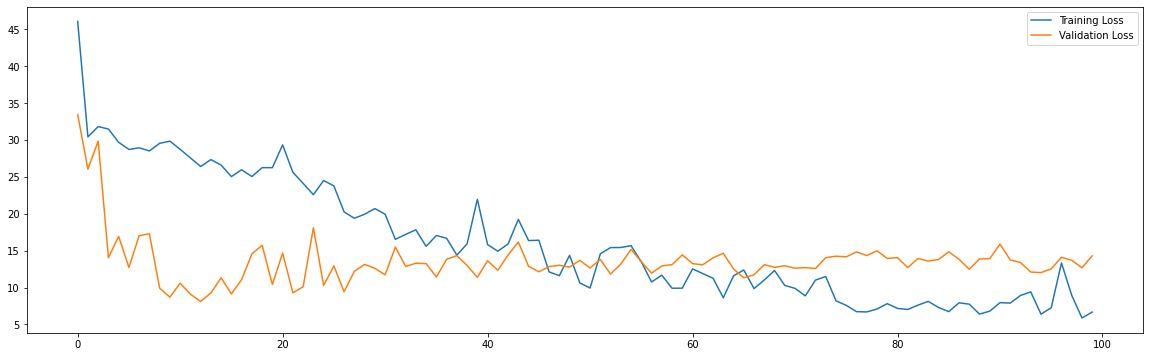

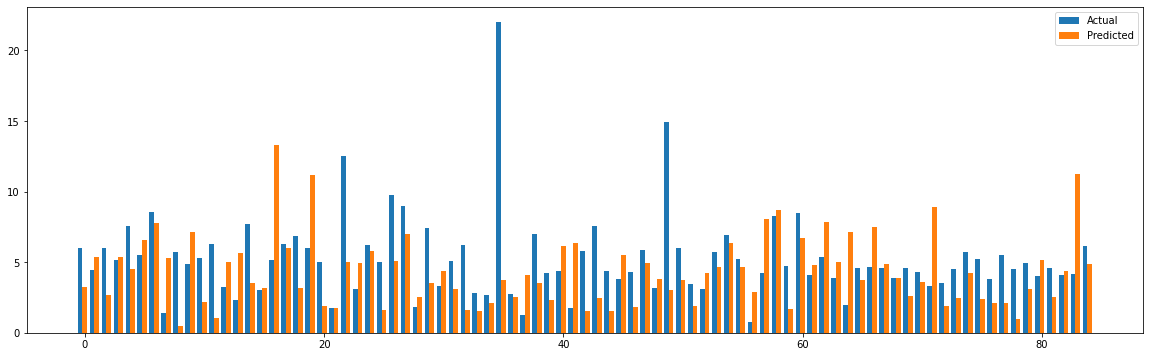

In [7]:
eval(model_cnn, history, test, test_y)

### With Augmentation
We will use the following:
* moderate translations
* small rotations
* moderate scale changes
* reflections on the X-axis

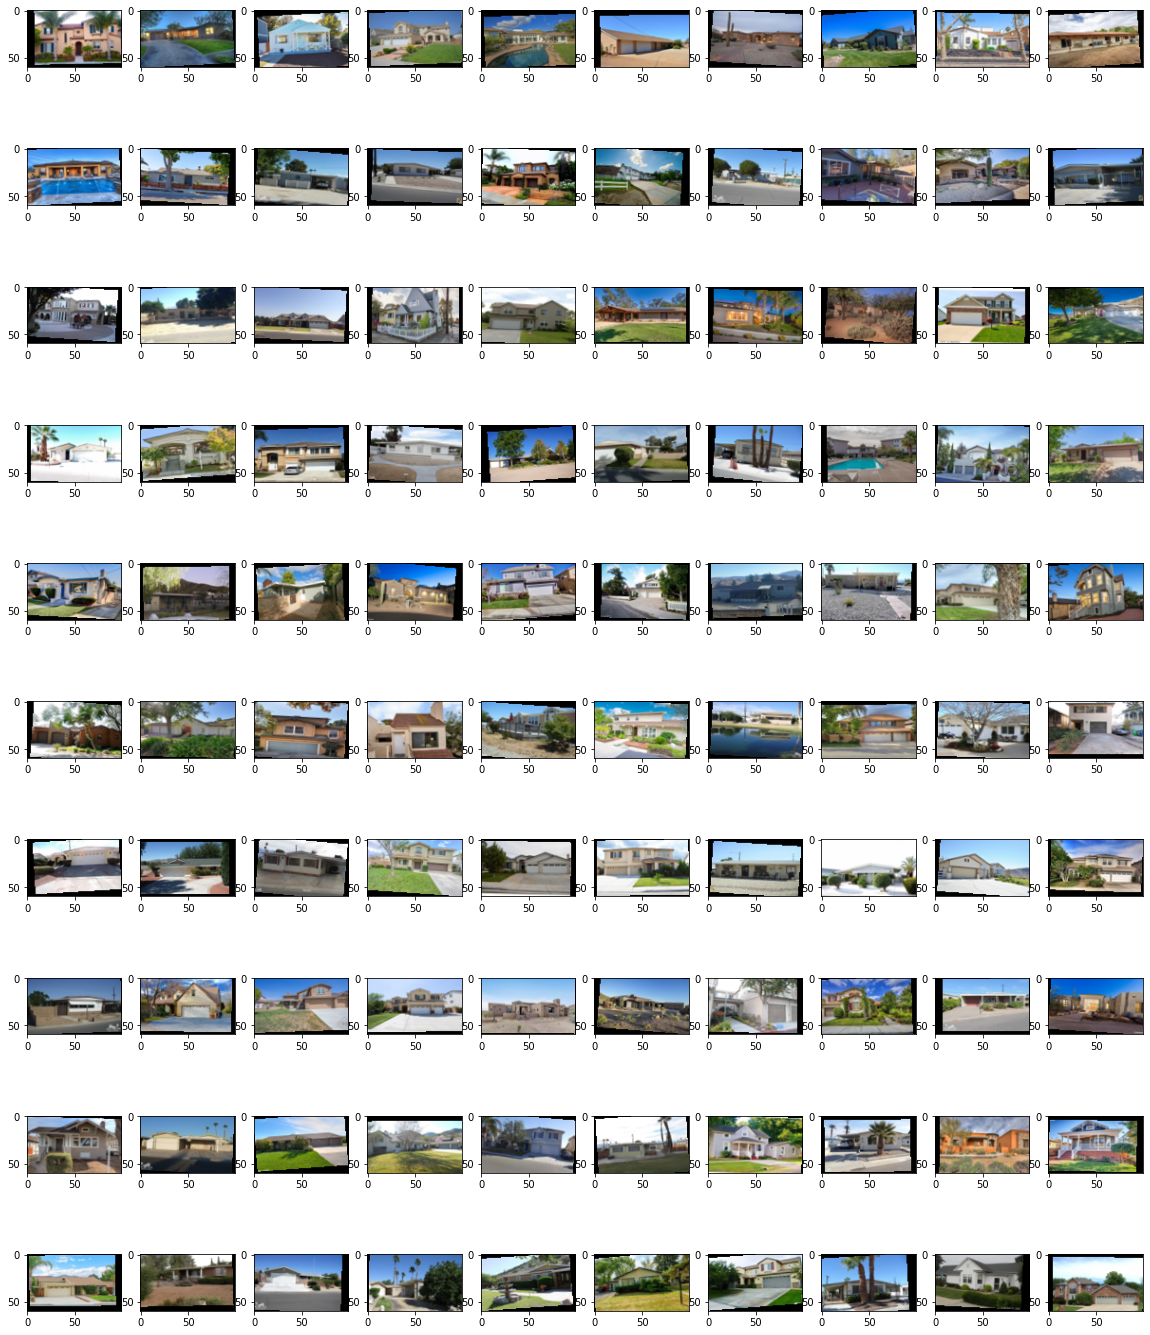

In [8]:
datagen = ImageDataGenerator(
                            # rotate between -5, +5 degrees
                            rotation_range=5,
                            # horiziontal shift by +/- 5% of the image width
                            width_shift_range=0.05,
                            # vertical shift by +/- 5% of the image width
                            height_shift_range=0.05,
                            # range for zooming
                            zoom_range=0.1,
                            # allow horizontal flips of data
                            horizontal_flip=True,
                            # what value to place in new pixels, given the nature of our data (clothes on a black backround)
                            # we'll set this to a constant value of 0
                            fill_mode='constant', cval=0)

batch = datagen.flow(train, train_y, batch_size=100)
fig = plt.figure(figsize=[20, 25])
for i,img in enumerate(batch[0][0]):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(img[:,:,:])

In [9]:
model_cnn = CreateModel()
model_cnn.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(datagen.flow(train, train_y, batch_size=16),
                    steps_per_epoch=450 // 16,
                    epochs=100,
                    validation_data=(test, test_y), verbose=False)

  ...
    to  
  ['...']


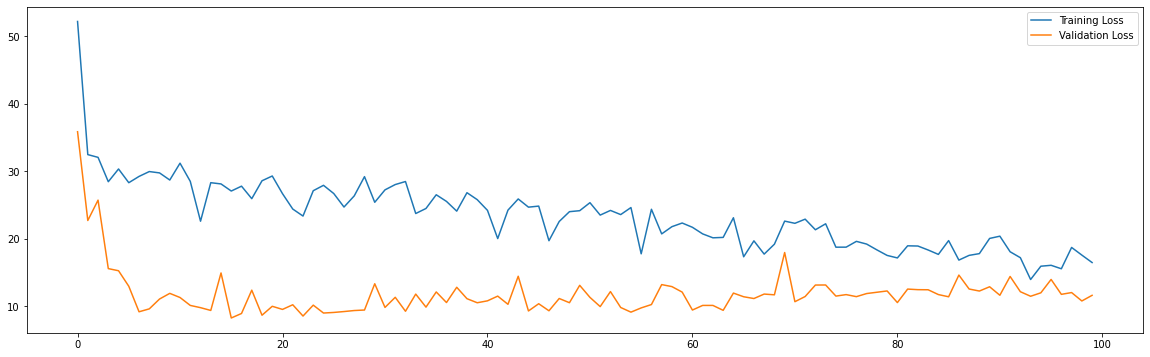

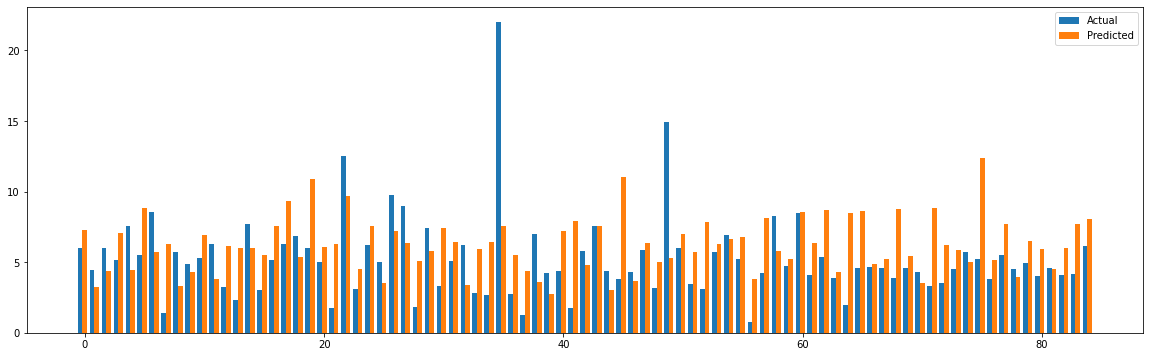

In [10]:
eval(model_cnn, history, test, test_y)

## All Images

Let's now repeat with all images

In [11]:
houses_data = scipy.io.loadmat('../../data/Houses/houses_all.mat')
train = houses_data['images_all'][:,:,:,0:1800]
train = numpy.transpose(train, (3, 0, 1, 2))
train_y = houses_data['costs_all'][0:1800]
test = houses_data['images_all'][:,:,:,1800:]
test = numpy.transpose(test, (3, 0, 1, 2))
test_y = houses_data['costs_all'][1800:]

### Without Augmentation

In [12]:
model_cnn = CreateModel()
model_cnn.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                    batch_size=16,
                    epochs=25,
                    validation_data=(test, test_y), verbose=False)

In [13]:
def eval(model_cnn, history, test, test_y):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()
    
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 1, 1)
    w = 0.4
    pos = numpy.arange(0, numpy.shape(test_y)[0], 1)
    ax.bar(pos-w, test_y[:,0], label="Actual", width=w)
    pred = model_cnn.predict(test)
    ax.bar(pos, pred[:,0], label="Predicted", width=w)
    ax.legend()

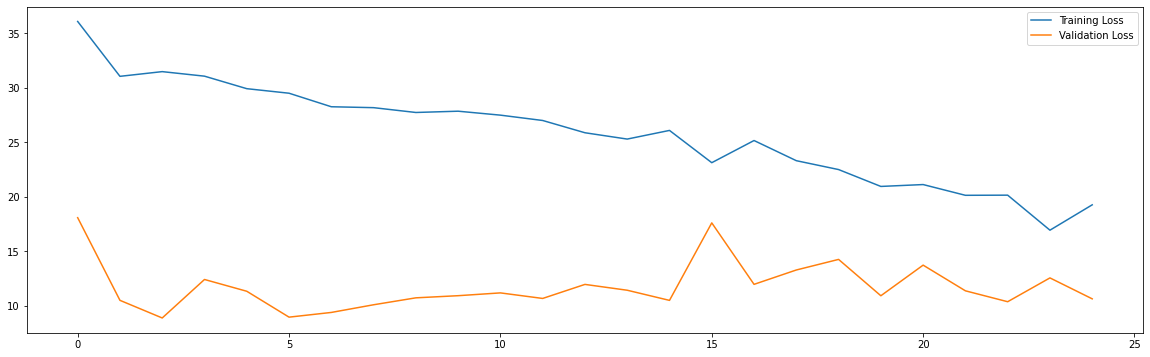

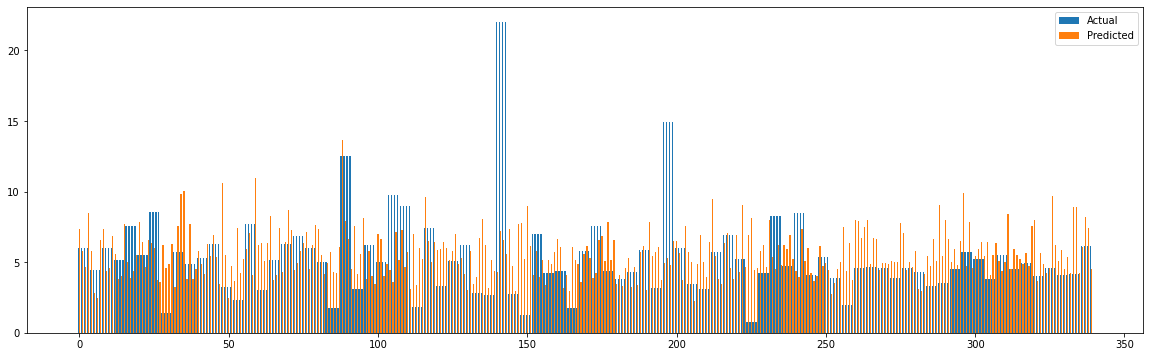

In [14]:
eval(model_cnn, history, test, test_y)

### With Augmentation
Same augmentation parameters as last time.

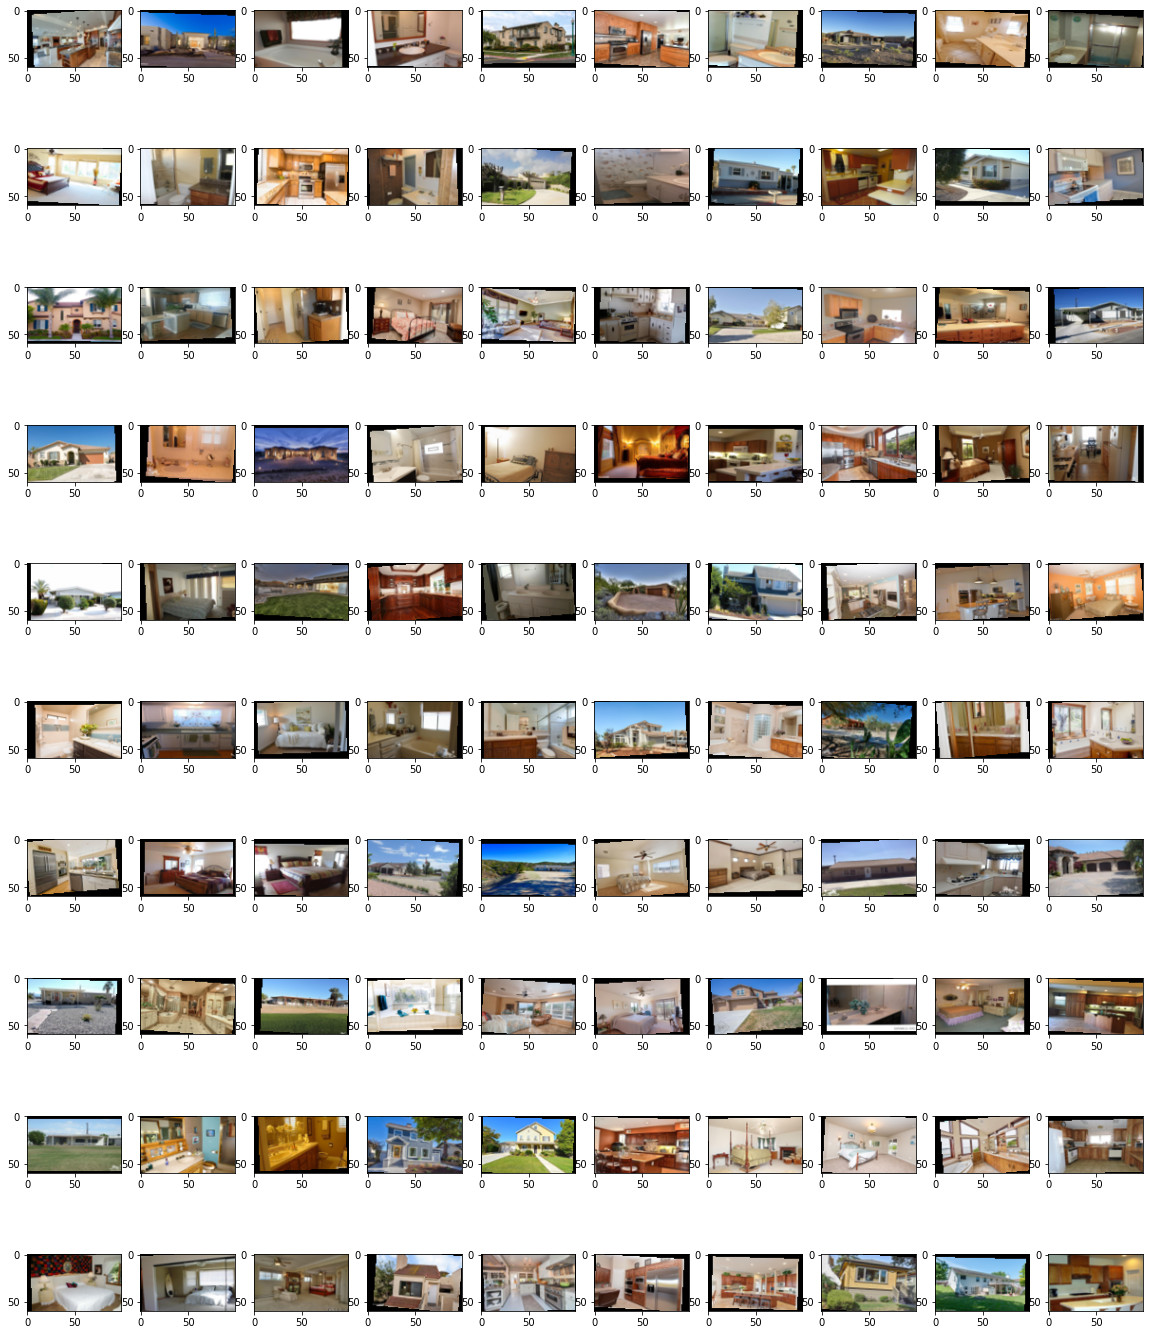

In [15]:
datagen = ImageDataGenerator(
                            # rotate between -5, +5 degrees
                            rotation_range=5,
                            # horiziontal shift by +/- 5% of the image width
                            width_shift_range=0.05,
                            # vertical shift by +/- 5% of the image width
                            height_shift_range=0.05,
                            # range for zooming
                            zoom_range=0.1,
                            # allow horizontal flips of data
                            horizontal_flip=True,
                            # what value to place in new pixels, given the nature of our data (clothes on a black backround)
                            # we'll set this to a constant value of 0
                            fill_mode='constant', cval=0)

batch = datagen.flow(train, train_y, batch_size=100)
fig = plt.figure(figsize=[20, 25])
for i,img in enumerate(batch[0][0]):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(img[:,:,:])

In [24]:
model_cnn = CreateModel()
model_cnn.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(datagen.flow(train, train_y, batch_size=16),
                    steps_per_epoch= 1800 // 16,
                    epochs=50,
                    validation_data=(test, test_y), verbose=False)

  ...
    to  
  ['...']


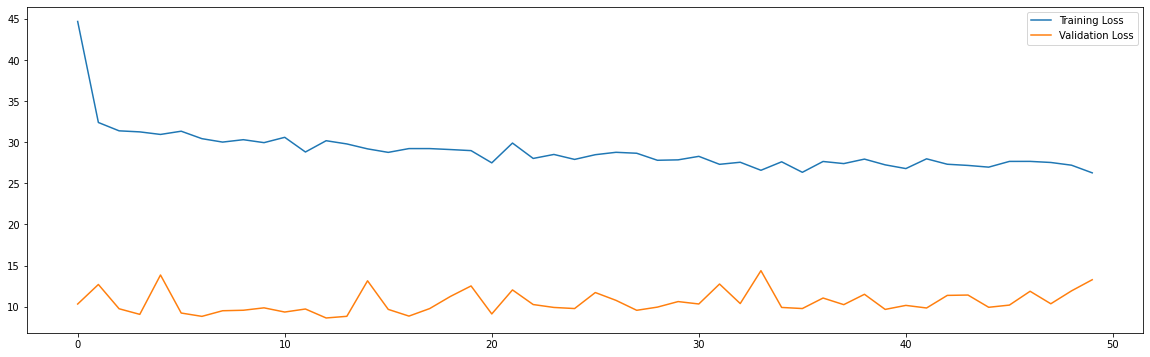

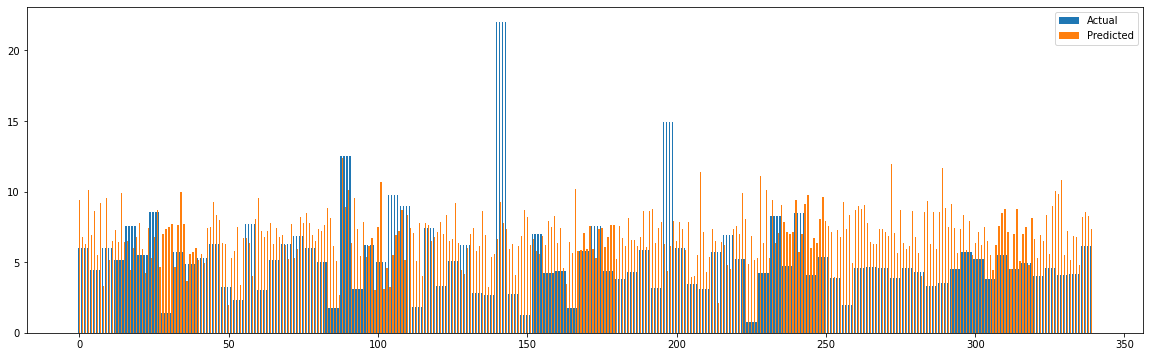

In [25]:
eval(model_cnn, history, test, test_y)

## Final Thoughts

Overall, when we use fine tuning we see slightly better performance. We don't a huge boost in accuracy, but we do see less overfitting going on which is a positive.

The second set of data is achieves less promising results, and we also see a big disconnect between training and validation loss. This is a little odd and perhaps counter intuitive, but suggests that maybe we could afford to add a little more capacity to the network. This will be left for you to experiment with in your own time.